# IPW-Learnerの理解

- 概要
  - 参考: https://github.com/st-tech/zr-obp/tree/master
- インプット
  - Context: 共変量
  - Action: 行動
  - Reward: 報酬
  - Propensity: 傾向スコア
- 学習
  - 下記を分類モデルに学習させる
    - X: Context
    - Y: Action
    - sample_weight: Reward / Propensity   
- 予測
  - 分類モデルにContextを入力すると、各行動の確率が出力される

In [108]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Case1. 線形効果 + ロジスティック回帰

- 設定
  - 200人のユーザー
  - Train:Test = 5:5
  - Treatment:Control = 90%:10%
  - 共変量は年齢のみ
  - 報酬は100 + 年齢 * action
- 期待
  - 年齢が高いユーザーをTreatmentとして推奨

In [109]:
N = 20000
np.random.seed(0)
age = np.random.randint(20, 60, N)
context = age
action = np.random.choice([0, 1], N, p=[1 - treatment_rate, treatment_rate])
reward = 100 + age * action
treatment_rate = 0.9
prpensity = np.where(action == 1, treatment_rate, (1 - treatment_rate))
sample_weight = reward / prpensity
train_flag = np.random.choice([0, 1], N, p=[0.5, 0.5])

In [110]:
# データフレームにまとめる
df = pd.DataFrame({
  'age': age, 
  'context': context, 
  'reward': reward, 
  'action': action, 
  'prpensity': prpensity, 
  'sample_weight': sample_weight, 
  'train_flag': train_flag
})
df

,age,context,reward,action,prpensity,sample_weight,train_flag
0,20,20,120,1,0.9,133.333333,0
1,23,23,123,1,0.9,136.666667,0
2,23,23,123,1,0.9,136.666667,0
3,59,59,159,1,0.9,176.666667,1
4,29,29,129,1,0.9,143.333333,0
...,...,...,...,...,...,...,...
19995,58,58,158,1,0.9,175.555556,1
19996,24,24,100,0,0.1,1000.000000,0
19997,53,53,153,1,0.9,170.000000,0
19998,48,48,148,1,0.9,164.444444,0


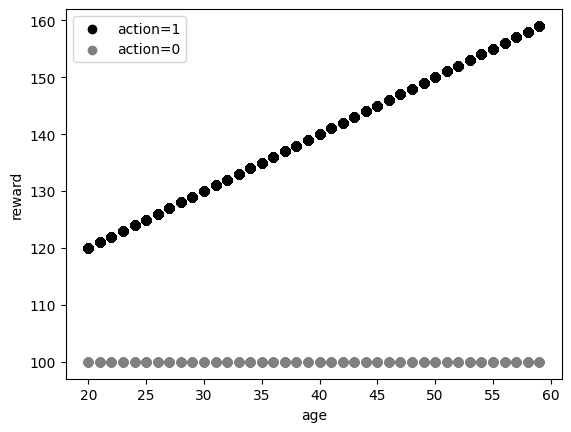

In [111]:
# contextとrewardのplot
plt.scatter(df.query('action == 1')['age'], df.query('action == 1')['reward'], c='black', label='action=1')
plt.scatter(df.query('action == 0')['age'], df.query('action == 0')['reward'], c='grey', label='action=0')
plt.xlabel('age')
plt.ylabel('reward')
plt.legend()
plt.show()

In [112]:
train_df = df[df['train_flag'] == 1]
test_df = df[df['train_flag'] == 0]

In [113]:
model = LogisticRegression()
model.fit(X = train_df[['context']], y = train_df['reward'], sample_weight = train_df['sample_weight']) 
test_df['pred'] = model.predict(test_df[['context']])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/tmp/ipykernel_4198/459830522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = model.predict(test_df[['context']])


In [114]:
# 年代ごとに予測された介入率を計算
test_df['pred'].groupby(test_df['age'] // 10 * 10).mean() / test_df['pred'].groupby(test_df['age'] // 10 * 10).count()

age
20    0.041883
30    0.040683
40    0.039386
50    0.045359
Name: pred, dtype: float64

### Case2. 非線形効果 + ロジスティック回帰

- 設定
  - 200人のユーザー
  - Train:Test = 5:5
  - Treatment:Control = 90%:10%
  - 共変量は年齢のみ
  - 報酬は下記
    - 40歳未満: 100 + 年齢 * action
    - 40歳以上: 100 + (80 - 年齢 * action)
- 期待
  - 40歳を推奨したいが、ロジスティック回帰では表現しきれない？

In [115]:
N = 20000
np.random.seed(0)
age = np.random.randint(20, 60, N)
context = age
action = np.random.choice([0, 1], N, p=[1 - treatment_rate, treatment_rate])
treatment_effect = np.where(age < 40, age, 80 - age)
reward = 100 + treatment_effect * action
treatment_rate = 0.9
prpensity = np.where(action == 1, treatment_rate, (1 - treatment_rate))
sample_weight = reward / prpensity
train_flag = np.random.choice([0, 1], N, p=[0.5, 0.5])

In [116]:
# データフレームにまとめる
df = pd.DataFrame({
  'age': age, 
  'context': context, 
  'reward': reward, 
  'action': action, 
  'prpensity': prpensity, 
  'sample_weight': sample_weight, 
  'train_flag': train_flag
})
df

,age,context,reward,action,prpensity,sample_weight,train_flag
0,20,20,120,1,0.9,133.333333,0
1,23,23,123,1,0.9,136.666667,0
2,23,23,123,1,0.9,136.666667,0
3,59,59,121,1,0.9,134.444444,1
4,29,29,129,1,0.9,143.333333,0
...,...,...,...,...,...,...,...
19995,58,58,122,1,0.9,135.555556,1
19996,24,24,100,0,0.1,1000.000000,0
19997,53,53,127,1,0.9,141.111111,0
19998,48,48,132,1,0.9,146.666667,0


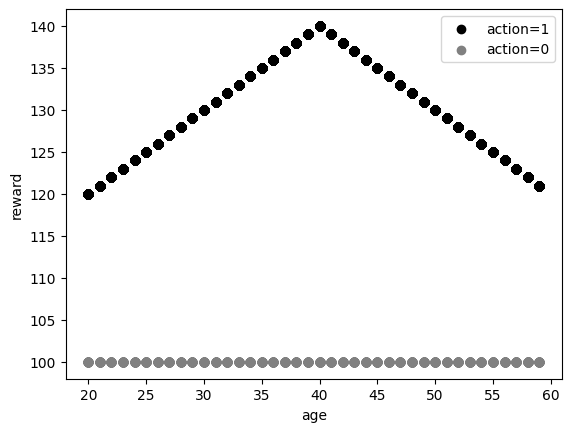

In [117]:
# contextとrewardのplot
plt.scatter(df.query('action == 1')['age'], df.query('action == 1')['reward'], c='black', label='action=1')
plt.scatter(df.query('action == 0')['age'], df.query('action == 0')['reward'], c='grey', label='action=0')
plt.xlabel('age')
plt.ylabel('reward')
plt.legend()
plt.show()

In [118]:
train_df = df[df['train_flag'] == 1]
test_df = df[df['train_flag'] == 0]

In [119]:
model = LogisticRegression()
model.fit(X = train_df[['context']], y = train_df['reward'], sample_weight = train_df['sample_weight']) 
test_df['pred'] = model.predict(test_df[['context']])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/tmp/ipykernel_4198/459830522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = model.predict(test_df[['context']])


In [120]:
# 年代ごとに予測された介入率を計算
test_df['pred'].groupby(test_df['age'] // 10 * 10).mean() / test_df['pred'].groupby(test_df['age'] // 10 * 10).count()

age
20    0.040723
30    0.040683
40    0.039386
50    0.040833
Name: pred, dtype: float64

### Case3. 非線形効果 + Random Forest

- 設定
  - 200人のユーザー
  - Train:Test = 5:5
  - Treatment:Control = 90%:10%
  - 共変量は年齢のみ
  - 報酬は下記
    - 40歳未満: 100 + (年齢 * action)
    - 40歳以上: 100 + (80 - 年齢 * action)
- 期待
  - 40歳を推奨したいが、非線形回帰では表現しきれない

In [121]:
N = 20000
np.random.seed(0)
age = np.random.randint(20, 60, N)
context = age
action = np.random.choice([0, 1], N, p=[1 - treatment_rate, treatment_rate])
treatment_effect = np.where(age < 40, age, 80 - age)
reward = 100 + treatment_effect * action
treatment_rate = 0.9
prpensity = np.where(action == 1, treatment_rate, (1 - treatment_rate))
sample_weight = reward / prpensity
train_flag = np.random.choice([0, 1], N, p=[0.5, 0.5])

In [122]:
# データフレームにまとめる
df = pd.DataFrame({
  'age': age, 
  'context': context, 
  'reward': reward, 
  'action': action, 
  'prpensity': prpensity, 
  'sample_weight': sample_weight, 
  'train_flag': train_flag
})
df

,age,context,reward,action,prpensity,sample_weight,train_flag
0,20,20,120,1,0.9,133.333333,0
1,23,23,123,1,0.9,136.666667,0
2,23,23,123,1,0.9,136.666667,0
3,59,59,121,1,0.9,134.444444,1
4,29,29,129,1,0.9,143.333333,0
...,...,...,...,...,...,...,...
19995,58,58,122,1,0.9,135.555556,1
19996,24,24,100,0,0.1,1000.000000,0
19997,53,53,127,1,0.9,141.111111,0
19998,48,48,132,1,0.9,146.666667,0


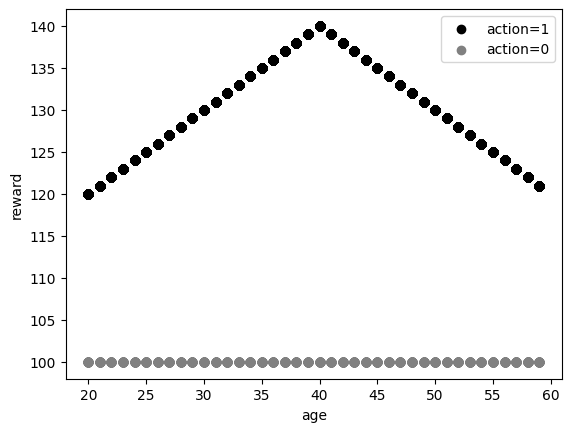

In [123]:
# contextとrewardのplot
plt.scatter(df.query('action == 1')['age'], df.query('action == 1')['reward'], c='black', label='action=1')
plt.scatter(df.query('action == 0')['age'], df.query('action == 0')['reward'], c='grey', label='action=0')
plt.xlabel('age')
plt.ylabel('reward')
plt.legend()
plt.show()

In [124]:
train_df = df[df['train_flag'] == 1]
test_df = df[df['train_flag'] == 0]

In [125]:
model = RandomForestClassifier()
model.fit(X = train_df[['context']], y = train_df['reward'], sample_weight = train_df['sample_weight']) 
test_df['pred'] = model.predict(test_df[['context']])

/var/tmp/ipykernel_4198/3960309345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = model.predict(test_df[['context']])


In [126]:
# 年代ごとに予測された介入率を計算
test_df['pred'].groupby(test_df['age'] // 10 * 10).mean() / test_df['pred'].groupby(test_df['age'] // 10 * 10).count()

age
20    0.048866
30    0.054686
40    0.053368
50    0.051247
Name: pred, dtype: float64